Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Assay information
Experimental determination of lipophillicity is most commonly carried out using a "shake flask" method where the analyte of interest is dissolved in a bi-phasic mixture of two immiscible liquids and after the system reaches equilibrium the concentrations of the analyte are measured in each phase. Then, the logarithm of the ratio of is taken. The most common solvent system is Octanol/Water which has become the standard experimental measure of lipophilicity in the medicinal chemistry space often called the partition coefficient, Poct/w . Explanation and image from [here](http://lokeylab.wikidot.com/shake-flask-logk).

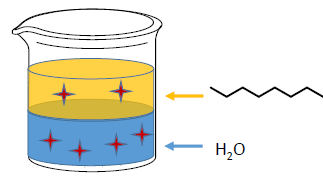

## Description of readout:
- **LOGD_74**: Octan-1-ol/water (pH7.4) distribution coefficent measured by a shake flask method described in J. Biomol. Screen. 2011, 16, 348-355.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301363/


## Curation reproducibility
The curation process in this notebook can be reproduced by command line:

```shell
auroris curate org-Polaris/astra_zeneca/logD/curation_config.json org-Polaris/astra_zeneca/logD
```

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pathlib

import pandas as pd
import datamol as dm

root = pathlib.Path("__file__").absolute().parents[3]
# set to recipe root directory
os.chdir(root)
sys.path.insert(0, str(root))

In [2]:
org = "polaris"
data_name = "logD_74"
dirname = dm.fs.join(root, f"org-{org}", "astra_zeneca", data_name)
gcp_root = f"gs://polaris-public/polaris-recipes/org-{org}/astra_zeneca/{data_name}"


# Load the data
source_data_path = 'gs://polaris-public/polaris-recipes/org-polaris/astra_zeneca/logD_74/CHEMBL3301363_raw.parquet'
data = pd.read_parquet(source_data_path)

In [3]:
dirname

'/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris-recipes/org-polaris/astra_zeneca/logD_74'

If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "LOGD_74",
    }
)

data

,SMILES,LOGD_74
0,COc1cc(F)ccc1-c1cncc(CNCC2CC2)n1,1.80
1,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)[C@@H]1CCN(Cc2ccc(...,1.80
2,COc1cc2c(c(OC)c1OC)-c1ccc(O)cc1[C@@H](NC(C)=O)CC2,1.81
3,N#Cc1cccc(S(=O)(=O)NC(=O)N2CCC(N3CCC(Oc4ccc(Cl...,1.81
4,CCOC(=O)c1coc2ccccc2c1=O,1.81
...,...,...
4195,CC[C@H]1OC(=O)[C@H](C)[C@@H](O[C@H]2C[C@@](C)(...,1.80
4196,COc1ccc(C(C)NC(=O)C2(N)CCN(c3ncnc4[nH]ccc34)CC...,1.80
4197,COc1cc(OC2CCNCC2)ccc1Nc1ncc(Cl)c(-c2cnc3ccccn2...,1.80
4198,CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...,1.80


### Run preliminary curation for data inspection

In [5]:
# Define data column names
data_cols = ["LOGD_74"]
mol_col = "SMILES"

In [6]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Deduplication, StereoIsomerACDetection, ContinuousDistributionVisualization

# Define the curation workflow
curator = Curator(
    data_path=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        ContinuousDistributionVisualization(y_cols=data_cols),
        OutlierDetection(method="zscore", columns=data_cols, threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=data_cols, threshold = 3)
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

curator.to_json(f"{dirname}/inspection_config.json")

In [7]:
# Run the curation step defined as above
data_inspection, report = curator(data)

2024-07-08 11:17:41.380 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-08 11:18:08.862 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-07-08 11:18:08.917 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-07-08 11:18:08.970 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [8]:
#  get the curation logger
from auroris.report.broadcaster import LoggerBroadcaster

broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-08 11:17:41
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 589.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== outlier_detection =====
[LOG]: New column added: OUTLIER_LOGD_74
[LOG]: Found 3 potential outliers with respect to the LOGD_74 column for review.
[IMG]: Dimensions 1200 x 600
====

In [9]:
# Generate an HTML report with embedded visualizations showcasing the data analysis.
from utils.auroris_utils import HTMLBroadcaster

# export report to local directory
broadcaster = HTMLBroadcaster(report, f"{dirname}/inspection_report")
report_path = broadcaster.broadcast()

In [10]:
# check the curated data
data_inspection.describe(include='all')

,SMILES,LOGD_74,MOL_smiles,MOL_molhash_id,MOL_molhash_id_no_stereo,MOL_num_stereoisomers,MOL_num_undefined_stereoisomers,MOL_num_defined_stereo_center,MOL_num_undefined_stereo_center,MOL_num_stereo_center,MOL_undefined_E_D,MOL_undefined_E/Z,OUTLIER_LOGD_74,AC_LOGD_74
count,4200,4200.000000,4200,4200,4200,4200.000000,4200.000000,4200.000000,4200.000000,4200.000000,4200,4200.0,4200,4200
unique,4198,NaN,4198,4198,4102,NaN,NaN,NaN,NaN,NaN,2,1.0,2,1
top,CN1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,NaN,CN1CCC[C@@H]1CCO[C@](C)(c1ccccc1)c1ccc(Cl)cc1,033c5f3caf6e82589bf5d8590e0b006577667f30,a42f41ec4838fe42b901c794265d1113cad19f92,NaN,NaN,NaN,NaN,NaN,False,0.0,False,False
freq,2,NaN,2,2,4,NaN,NaN,NaN,NaN,NaN,3667,4200.0,4197,4200
mean,NaN,2.186336,NaN,NaN,NaN,139.816905,1.337857,0.440714,0.161429,0.602143,NaN,NaN,NaN,NaN
std,NaN,1.203004,NaN,NaN,NaN,8107.004015,8.000470,1.051115,0.460011,1.110707,NaN,NaN,NaN,NaN
min,NaN,-1.500000,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
25%,NaN,1.410000,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
50%,NaN,2.360000,NaN,NaN,NaN,1.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN
75%,NaN,3.100000,NaN,NaN,NaN,2.000000,1.000000,1.000000,0.000000,1.000000,NaN,NaN,NaN,NaN


## Signals or outliers

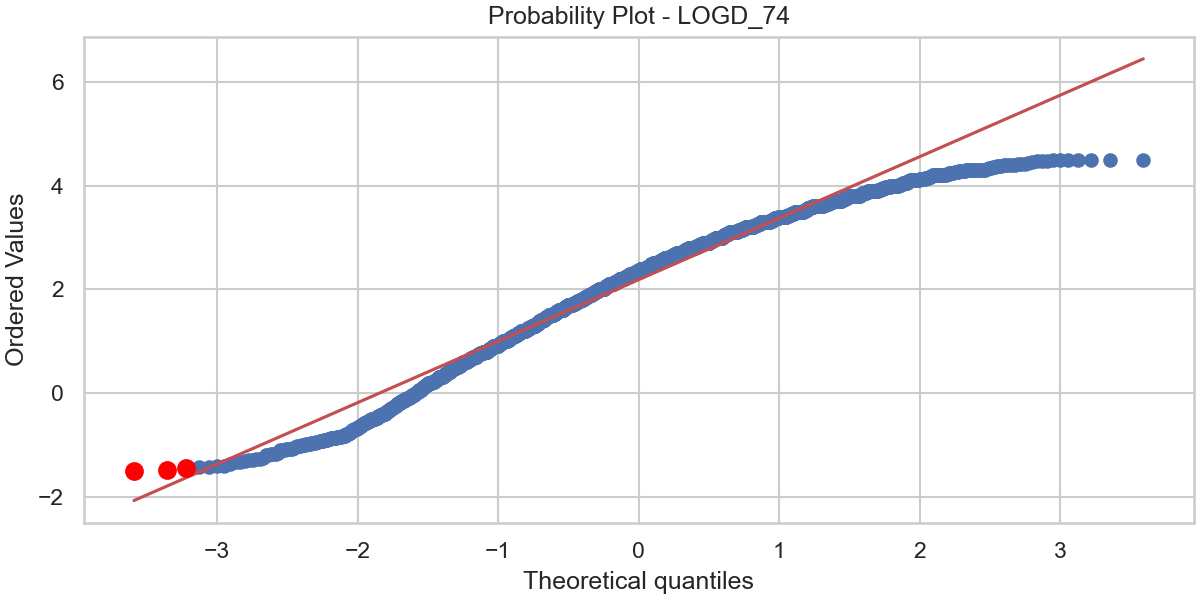

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

## Chemical space coverage of the dataset

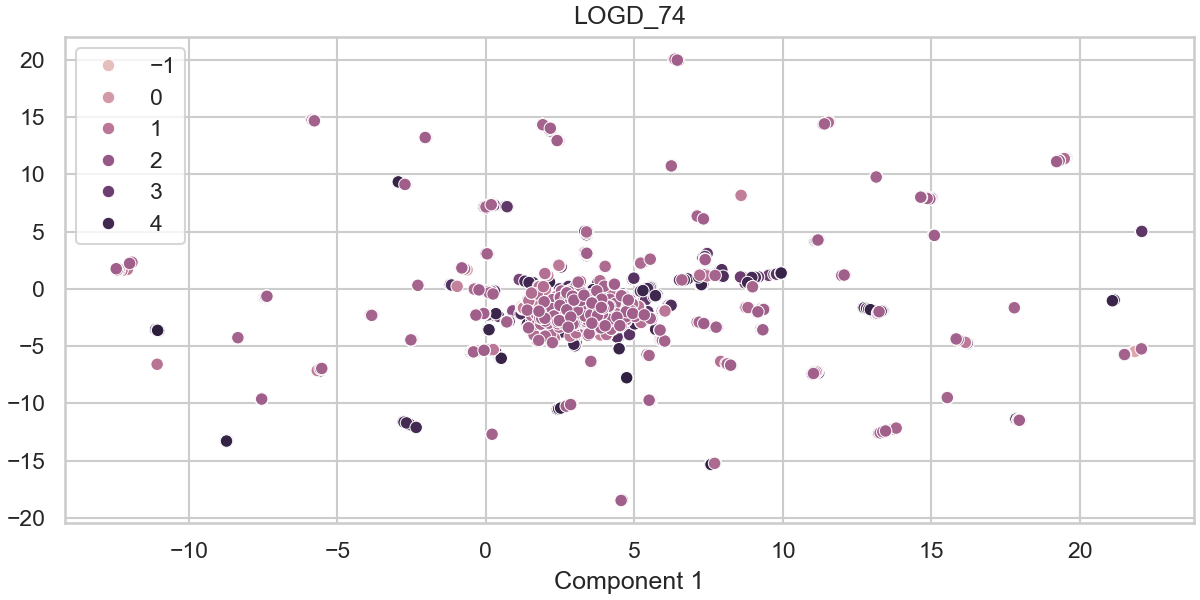

### Re-run curation, removing molecules as needed

In [12]:
# import key curation components from auroris
from auroris.curation import Curator
from auroris.curation.actions import MoleculeCuration, OutlierDetection, Deduplication, StereoIsomerACDetection, ContinuousDistributionVisualization

# Define the curation workflow
curator = Curator(
    data_path=source_data_path, 
    steps=[
        MoleculeCuration(input_column=mol_col, y_cols = data_cols),
        ContinuousDistributionVisualization(y_cols=data_cols),
        Deduplication(deduplicate_on=mol_col, y_cols=data_cols), # remove the replicated molecules
        OutlierDetection(method="zscore", columns=data_cols, threshold = 3, use_modified_zscore=True),
        StereoIsomerACDetection(y_cols=data_cols, threshold = 3)
    ],
    parallelized_kwargs = { "n_jobs": -1 }
)

In [13]:
# The final curation configuration is exported for reproducibility
path = f"{gcp_root}/data/curation/curation_config.json"
curator.to_json(path)

In [14]:
# Run the curation step defined as above
data_curated, report = curator(data)

2024-07-08 11:22:34.592 | INFO     | auroris.curation._curator:transform:106 - Performing step: mol_curation
2024-07-08 11:22:43.277 | INFO     | auroris.curation._curator:transform:106 - Performing step: distribution
2024-07-08 11:22:43.335 | INFO     | auroris.curation._curator:transform:106 - Performing step: deduplicate
2024-07-08 11:22:45.366 | INFO     | auroris.curation._curator:transform:106 - Performing step: outlier_detection
2024-07-08 11:22:45.416 | INFO     | auroris.curation._curator:transform:106 - Performing step: ac_stereoisomer


In [15]:
broadcaster = LoggerBroadcaster(report)
broadcaster.broadcast()

===== Curation Report =====
Time: 2024-07-08 11:22:34
Version: dev
===== mol_curation =====
[LOG]: New column added: MOL_smiles
[LOG]: New column added: MOL_molhash_id
[LOG]: New column added: MOL_molhash_id_no_stereo
[LOG]: New column added: MOL_num_stereoisomers
[LOG]: New column added: MOL_num_undefined_stereoisomers
[LOG]: New column added: MOL_num_defined_stereo_center
[LOG]: New column added: MOL_num_undefined_stereo_center
[LOG]: New column added: MOL_num_stereo_center
[LOG]: New column added: MOL_undefined_E_D
[LOG]: New column added: MOL_undefined_E/Z
[LOG]: Default `ecfp` fingerprint is used to visualize the chemical space.
[LOG]: Molecules with undefined stereocenter detected: 589.
[IMG]: Dimensions 1200 x 600
[IMG]: Dimensions 1200 x 2400
===== distribution =====
[IMG]: Dimensions 1200 x 600
===== deduplicate =====
[LOG]: Deduplication merged and removed 2 duplicated molecules from dataset
===== outlier_detection =====
[LOG]: New column added: OUTLIER_LOGD_74
[LOG]: Found 3

In [16]:
# Export report to polaris public directory on GCP
# The report is ready to reviewed in the HTML file.
broadcaster = HTMLBroadcaster(report, f"{gcp_root}/data/curation/report", embed_images=True)
broadcaster.broadcast()

'gs://polaris-public/polaris-recipes/org-polaris/astra_zeneca/logD_74/data/curation/report/index.html'

## Export the final curated data

In [17]:
fout = f"{gcp_root}/data/curation/{data_name}_curated.csv"
data_curated.reset_index(drop=True).to_csv(fout, index=False)